# Camera Calibration Pipeline 
Insert the folder where the checkerboard markers are stored in the `data_folder`

## Open a video and pull the frames to put into a folder

In [87]:
import cv2

def select_frames(video_file, skip_frames=100, start_frame=0):
    """
    Allows the user to manually select frames from a video file for inspection and saving.

    Args:
        video_file (str): The path to the video file.
        skip_frames (int, optional): The number of frames to skip between selections. Defaults to 100.
        start_frame (int, optional): The starting frame index. Defaults to 0.

    Returns:
        None

    Displays each frame of the video file, allowing the user to inspect and save frames.
    Checkerboard patterns should have the entire board visible, without occlusions. 
    Aruco or Charuco boards should be in focus as possible. 
    Only full markers will be detected, but only a partial pattern need be visible.

    Controls:
        - Press 'S' to save the current frame.
        - Press 'A' to skip to the next frame.
        - Press 'Q' to quit the selection process.

    Saved frames will be stored in the 'Frames' directory alongside the video file.

    Note:
        This function uses OpenCV for video capture and frame manipulation.
    """
    
    cap = cv2.VideoCapture(video_file)
    if not cap.isOpened():
        print("Error: Could not open video file.")
        return
    
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    current_frame = start_frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    print("Please inspect each frame. Checkerboard patterns should have the entire board visible, without occlusions. Aruco or Charuco boards should be in focus as possible. Only full markers will be detected, but only a partial pattern need be visible.")
    print("Press 'S' to save the frame, 'A' to try the next frame, or 'Q' to quit")

    while current_frame<frame_count:
        ret, frame = cap.read()
        if not ret:
            break
        
        cv2.namedWindow('Frame', cv2.WINDOW_NORMAL)  # Make the window resizable
        cv2.resizeWindow('Frame', 640, 480)
        cv2.imshow('Frame', frame)
        cv2.putText(frame, f'Frame: {current_frame}/{frame_count}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        key = cv2.waitKey(0)
        
        # Save on S
        if key == ord('s'):
            d = video_file.rsplit(sep='\\', maxsplit = 1)[0] + f'\\Frames\\frame_{current_frame}.jpg'
            cv2.imwrite(d, frame)
            print(f"Frame {current_frame} saved at {d}")
            current_frame += skip_frames
        # Move to the next frame on D
        elif key == ord('a'):
            current_frame += skip_frames

        # Exit on Q
        elif key == ord('q'):
            break

        cap.set(cv2.CAP_PROP_POS_FRAMES, current_frame)
    cap.release()
    cv2.destroyAllWindows()

In [97]:
video_file_chess = r'C:\PhieldsCalibrationData\Aeon2Calib\3DAcquisistion\2024-03-21T11-47-02\Camera1\Camera1_2024-03-21T11-00-00.avi'
video_file_charuco = r'C:\PhieldsCalibrationData\Aeon2Calib\3DAcquisistion\2024-03-21T11-48-18\Camera3\Camera3_2024-03-21T11-00-00.avi'
select_frames(video_file_charuco, skip_frames=50, start_frame=0)

Please inspect each frame. Checkerboard patterns should have the entire board visible, without occlusions. Aruco or Charuco boards should be in focus as possible. Only full markers will be detected, but only a partial pattern need be visible.
Press 'S' to save the frame, 'A' to try the next frame, or 'Q' to quit
Frame 0 saved at C:\PhieldsCalibrationData\Aeon2Calib\3DAcquisistion\2024-03-21T11-48-18\Camera3\Frames\frame_0.jpg
Frame 250 saved at C:\PhieldsCalibrationData\Aeon2Calib\3DAcquisistion\2024-03-21T11-48-18\Camera3\Frames\frame_250.jpg
Frame 300 saved at C:\PhieldsCalibrationData\Aeon2Calib\3DAcquisistion\2024-03-21T11-48-18\Camera3\Frames\frame_300.jpg
Frame 350 saved at C:\PhieldsCalibrationData\Aeon2Calib\3DAcquisistion\2024-03-21T11-48-18\Camera3\Frames\frame_350.jpg
Frame 400 saved at C:\PhieldsCalibrationData\Aeon2Calib\3DAcquisistion\2024-03-21T11-48-18\Camera3\Frames\frame_400.jpg
Frame 450 saved at C:\PhieldsCalibrationData\Aeon2Calib\3DAcquisistion\2024-03-21T11-48-18

In [98]:
import os
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import argparse
from cv2 import aruco

charuco_root = r"C:\PhieldsCalibrationData\Aeon2Calib\3DAcquisistion\2024-03-21T11-48-18\\"
chessboard_root = r"C:\PhieldsCalibrationData\Aeon2Calib\3DAcquisistion\2024-03-21T11-47-02\\"
######################################################################################
data_folder_camera1 = chessboard_root + r"Camera1\Frames\\"
data_folder_camera2 = chessboard_root + r"Camera2\Frames\\"
data_folder_camera3 = chessboard_root + r"Camera3\Frames\\"
######################################################################################
charuco_data_folder_camera1 = charuco_root + r"Camera1\Frames\\"
charuco_data_folder_camera2 = charuco_root + r"Camera2\Frames\\"
charuco_data_folder_camera3 = charuco_root + r"Camera3\Frames\\"
######################################################################################

datafolders_chess = [data_folder_camera1,data_folder_camera2,data_folder_camera3]
datafolders_charuco = [charuco_data_folder_camera1,charuco_data_folder_camera2,charuco_data_folder_camera3]

### Calculate camera parameters 
Run calibrate camera from opencv using all the checkerboard points found on each image.
Create function to run through all images saved in a datafolder for chessboard calibration. Can save (optional) calibration values in a calibration.yml (save = True)

In [106]:
def ChessboardCalibrate(datafolder, patternsize = (14, 19), report = True, save = False):
    """
    Calibrates a camera using images of a chessboard pattern.

    Args:
        datafolder (str): The folder path containing images of the chessboard pattern.
        patternsize (tuple, optional): The dimensions of the chessboard pattern (rows, columns). Defaults to (14, 19).
        report (bool, optional): Whether to print calibration report. Defaults to True.
        save (bool, optional): Whether to save calibration data. Defaults to False.

    Returns:
        tuple: A tuple containing:
            - reproj_error (float): Reprojection error of the calibration.
            - intrinsics (numpy.ndarray): Camera intrinsic matrix.
            - distortion (numpy.ndarray): Distortion coefficients.
            - rvecs (list): Rotation vectors for each calibration image.
            - tvecs (list): Translation vectors for each calibration image.
            - imagePoints (list): Image coordinates of detected corners.
            - objectPoints (list): Object coordinates of detected corners.
            - fnames_chessboard_found (list): File names of images where the chessboard pattern was found (for undistorting).

    Calibrates a camera using images of a chessboard pattern. 
    Each image in the specified data folder is processed to detect the chessboard corners. 
    If the chessboard pattern is found, corresponding object points (3D) and image points (2D) are stored.
    The camera is then calibrated using the collected points.

    If 'report' is set to True, a calibration report including the reprojection error and principal points is printed.
    If 'save' is set to True, the calibration data is saved to a YAML file named 'Calibration.yml' in the datafolder.

    Note:
        This function uses OpenCV for camera calibration and image processing.
"""

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    pattern = np.zeros((1, patternsize[0] * patternsize[1], 3), np.float32)
    pattern[0,:,:2] = np.mgrid[0:patternsize[0], 0:patternsize[1]].T.reshape(-1, 2) * 0.001 # size of pattern in real world (m) to put objpoints into correct scale
    fnames = glob.glob(datafolder + '/*.jpg')
    fnames_chessboard_found = []
    objectPoints = []
    imagePoints = []

    for fname in fnames:
        if report:
            print("Processing {0}...".format(os.path.split(fname)[-1]), end=" ")
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        flags = cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE
        ret, corners = cv2.findChessboardCorners(gray, patternsize, flags)
        if ret:
            if report:
                print("Success")  
            fnames_chessboard_found.append(fname)
        else: 
            if report:
                print("Not found!")
        
        if ret:
            corners = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
            objectPoints.append(pattern)
            imagePoints.append(corners)
            
            img = cv2.drawChessboardCorners(img, patternsize, corners, ret)
        if report:
            plt.figure()
            plt.imshow(img)
            plt.draw()
    if report:
        print("Calibrating camera with {0} points from {1} images...".format(
            np.prod(np.array(imagePoints).shape) // 2,
            len(imagePoints)))
    reproj_error, intrinsics, distortion, rvecs, tvecs = cv2.calibrateCamera(objectPoints, imagePoints, gray.shape[::-1], None, None)

    if report:
        print(f"Reprojection error: {reproj_error}")
        print(f'Principle points: ({intrinsics[0,2]} / {img.shape[1]/2}) : {intrinsics[1,2]} / {img.shape[0]/2}')

    if save:
        sname = "{0}\\Calibration.yml".format(os.path.split(fname)[0])
        print("Writing calibration file {0}...".format(sname))
        flags = cv2.FILE_STORAGE_FORMAT_YAML + cv2.FILE_STORAGE_WRITE
        s = cv2.FileStorage(sname,flags)
        s.write('image_width', img.shape[1])
        s.write('image_height', img.shape[0])
        s.write('camera_matrix', intrinsics)
        s.write('distortion_coefficients', distortion)
        s.write('reprojection_error', reproj_error)
        s.release()

    return reproj_error, intrinsics, distortion, rvecs, tvecs, imagePoints, objectPoints, fnames_chessboard_found

In [107]:
def undistortChessboard(fnames,imagePoints,intrinsics, distortion, patternsize = (14, 19), report = True):
    for i,fname in enumerate(fnames):
        if report:
            print("Undistorting {0}...".format(os.path.split(fname)[-1]))
        img = cv2.imread(fname)
        img = cv2.drawChessboardCorners(img, patternsize, imagePoints[i], True)
    
        uimg = cv2.undistort(img, intrinsics, distortion)
        if i ==0 and report:
            plt.figure()
            plt.imshow(uimg)
            plt.draw()

## Now calibrate using chessboard markers. Loop through chessboard folders for each of the three cameras

In [109]:
for datafolder in datafolders_chess:
    reproj_error, intrinsics, distortion, rvecs, tvecs, imagePoints, objectPoints, fnames = ChessboardCalibrate(datafolder, report = False, save = True)
    undistortChessboard(fnames,imagePoints,intrinsics, distortion, report = False)

for datafolder in datafolders_charuco:
    reproj_error, intrinsics, distortion, rvecs, tvecs, imagePoints, objectPoints, fnames = ChessboardCalibrate(datafolder, report = False, save = True)
    undistortChessboard(fnames,imagePoints,intrinsics, distortion, report = False)

Writing calibration file C:\PhieldsCalibrationData\Aeon2Calib\3DAcquisistion\2024-03-21T11-47-02\\Camera1\Frames\Calibration.yml...
Writing calibration file C:\PhieldsCalibrationData\Aeon2Calib\3DAcquisistion\2024-03-21T11-47-02\\Camera2\Frames\Calibration.yml...
Writing calibration file C:\PhieldsCalibrationData\Aeon2Calib\3DAcquisistion\2024-03-21T11-47-02\\Camera3\Frames\Calibration.yml...
Writing calibration file C:\PhieldsCalibrationData\Aeon2Calib\3DAcquisistion\2024-03-21T11-48-18\\Camera1\Frames\Calibration.yml...
Writing calibration file C:\PhieldsCalibrationData\Aeon2Calib\3DAcquisistion\2024-03-21T11-48-18\\Camera2\Frames\Calibration.yml...
Writing calibration file C:\PhieldsCalibrationData\Aeon2Calib\3DAcquisistion\2024-03-21T11-48-18\\Camera3\Frames\Calibration.yml...


## Check parallel markers lie on a straight line

In [36]:
from sklearn.linear_model import LinearRegression

ii = 2
points = imagePoints[0][ii*14:(ii*14)+14]
x = []
y = []
for point in points:
    x.append(point[0][0])
    y.append(point[0][1])
x=np.array(x)
y=np.array(y)
x = x.reshape(-1, 1)

model = LinearRegression()
model.fit(x, y)

r_squared = model.score(x, y)
r_squared

0.999999477288764

## Pose estimation for extrinsic parameter computation with Aruco Markers

In [54]:
# Set ARUCO marker parameters
ARUCO_DICT = aruco.DICT_4X4_1000   # Dictionary ID
# ARUCO_DICT = aruco.DICT_ARUCO_ORIGINAL
SQUARES_VERTICALLY = 20             # Number of squares vertically
SQUARES_HORIZONTALLY = 15             # Number of squares horizontally
SQUARE_LENGTH = 10                   # Square side length (in pixels)
MARKER_LENGTH = 7                   # ArUco marker side length (in pixels)
MARGIN_PX = 20                       # Margins size (in pixels)                    # Margins size (in pixels)
dictionary = cv2.aruco.getPredefinedDictionary(ARUCO_DICT)
board = cv2.aruco.CharucoBoard((SQUARES_VERTICALLY, SQUARES_HORIZONTALLY), SQUARE_LENGTH, MARKER_LENGTH, dictionary)

In [113]:
def get_marker_corners(datafolder):
    """
    Detects marker corners in images and extracts Charuco board corners and IDs.

    Args:
        datafolder (str): The folder path containing images.

    Returns:
        tuple: A tuple containing:
            - corners (list): Detected marker corners for each image.
            - ids (list): Detected marker IDs for each image.
            - all_charuco_corners (list): Extracted Charuco board corners for each image.
            - all_charuco_ids (list): Extracted Charuco board IDs for each image.
            - image_files (list): File paths of the processed images.

    Detects marker corners in images using the ArUco detector. 
    Extracts Charuco board corners and IDs using detected marker corners and IDs.

    Note:
        This function uses OpenCV for marker detection and Charuco corner interpolation.

    Example:
        corners, ids, all_charuco_corners, all_charuco_ids, image_files = get_marker_corners('marker_images')
    """
    # Define the aruco dictionary, charuco board and detector
    dictionary = cv2.aruco.getPredefinedDictionary(ARUCO_DICT)
    board = cv2.aruco.CharucoBoard((SQUARES_VERTICALLY, SQUARES_HORIZONTALLY), SQUARE_LENGTH, MARKER_LENGTH, dictionary)
    params = cv2.aruco.DetectorParameters()
    detector = cv2.aruco.ArucoDetector(dictionary, params)
    
    # Load images from directory
    image_files = [os.path.join(datafolder, f) for f in os.listdir(datafolder) if f.endswith(".jpg")]
    all_charuco_ids = []
    all_charuco_corners = []
    corners, ids =[],[]
    # Loop over images and extraction of corners
    for image_file in image_files:
        image = cv2.imread(image_file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        imgSize = image.shape
        image_copy = image.copy()
        marker_corners, marker_ids, _ = detector.detectMarkers(image)
        corners.append(marker_corners)
        ids.append(marker_ids)
        if len(marker_ids) > 0: # If at least one marker is detected
            cv2.aruco.drawDetectedMarkers(image_copy, marker_corners, marker_ids)
            ret, charucoCorners, charucoIds = cv2.aruco.interpolateCornersCharuco(marker_corners, marker_ids, image, board)

            if marker_ids is not None and charucoCorners is not None and len(charucoCorners) > 0:
                all_charuco_corners.append(charucoCorners)
                all_charuco_ids.append(charucoIds)
    return corners, ids, all_charuco_corners, all_charuco_ids, image_files

# Collect extrinsic paramters for each camera

In [112]:
marker_cornersS, marker_idS, image_filesS = [],[],[]
datafolder = datafolders_charuco[0]

for datafolder in datafolders_charuco:
    
    marker_corners, marker_ids, all_charuco_corners, all_charuco_ids, image_files = get_marker_corners(datafolder)

TypeError: object of type 'NoneType' has no len()

In [47]:
def my_estimatePoseSingleMarker(corners, marker_size, mtx, distortion):
    '''
    Estimates the rotation and translation vectors for each detected marker corner.

    Args:
        corners (list): Detected marker corners for each marker.
        marker_size (float): Size of the detected markers.
        mtx (numpy.ndarray): Camera matrix.
        distortion (numpy.ndarray): Camera distortion matrix.

    Returns:
        tuple: A tuple containing:
            - rvecs (list): Rotation vectors for each detected marker corner.
            - tvecs (list): Translation vectors for each detected marker corner.
            - trash (list): Placeholder list corresponding to the old estimatePoseSingleMarkers().

    This function estimates the rotation and translation vectors (rvecs and tvecs) for each detected marker corner.
    It uses solvePnP with IPPE algorithm to estimate the pose.

    Note:
        This function uses OpenCV for camera pose estimation.

    '''
    marker_points = np.array([[-marker_size / 2, marker_size / 2, 0],
                              [marker_size / 2, marker_size / 2, 0],
                              [marker_size / 2, -marker_size / 2, 0],
                              [-marker_size / 2, -marker_size / 2, 0]], dtype=np.float32)
    trash = []
    rvecs = []
    tvecs = []
    for c in corners:
        nada, R, t = cv2.solvePnP(marker_points, c, mtx, distortion, False, cv2.SOLVEPNP_IPPE_SQUARE)
        rvecs.append(R)
        tvecs.append(t)
        trash.append(nada)
    return rvecs, tvecs, trash

[array([[ 92.09116109],
        [ -5.16571209],
        [864.72686232]])]

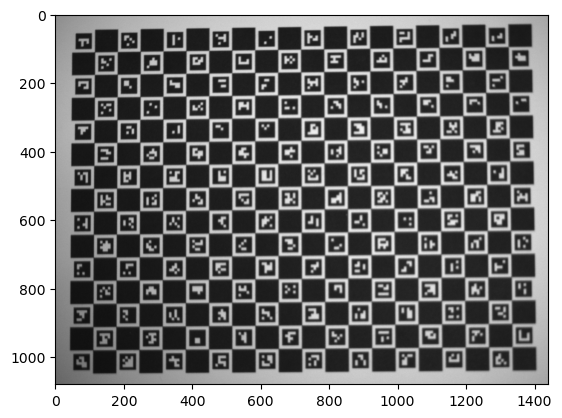

In [49]:
n = 0
plt.figure()
plt.imshow(cv2.imread(image_files[n]))
rvecs,tvecs,_=my_estimatePoseSingleMarker(marker_corners[n][75],7,intrinsics,distortion)
tvecs

## Things to try next

Manual calibration and automatic calibration give us similar ballpark figures

Try estimating pose with all charuco board

What does FOV mean in opencv?

Check when 